# Elements of Data Science 

# COMS W4995 007 2018 3


## Week 4: Statistical Modeling and Hypothesis Testing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('white')

np.random.seed(123)

%matplotlib inline

## Today:

- Random Sampling
- Confidence Intervals
- A/B Tests
- Hypothesis Testing
- Permutation Tests
- p-values
- Calculating power
- Multi-Armed Bandit


## Questions and more questions

- Have web conversions gone up?
- Have stock prices changed?
- Which ad generates more sales?
- Which headline generates more clicks?
- Did the number of likes change?
- How long till the product fails?
- How long till we get the next customer call?
- How many calls are we likely to get?

## Population Distributions and Sampling

- **Population Distribution** : The actual distribution out in the world

- **Random Sample** : Sample does not differ systematically from population it comes from

 - **Sample Size** (*n*) : The number of observations, the larger the better

 - **Sample Statistic** : eg. mean, median, standard deviation

 - **Sampling Distribution** : Distribution of the sample statistic

 - **Population Mean** vs. **Sample Mean** : $\mu$ vs. $\bar{x}$

 - **Population** vs **Sample Std. Var.** : $\sigma$ vs. $s$

## What we'd like to know first

 - sample size
 - shape
 - location
 - spread

## Example

In [2]:
df = pd.read_csv('../data/yellow_tripdata_2017-01_subset10000rows.csv')

# imagine this is our population distribution
trip_distance = df.trip_distance.dropna().iloc[:1000]

In [4]:
# sample size
n = 30

# take a sample from the population
idx = np.random.permutation(len(trip_distance))

sample_idx = idx[:n]

sample = trip_distance.iloc[sample_idx]

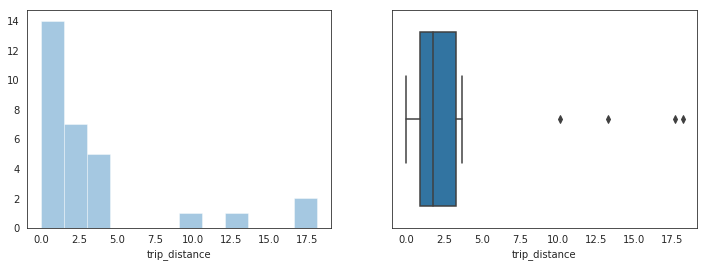

In [6]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
_ = sns.distplot(sample, kde=False, ax=ax[0])
_ = sns.boxplot(sample, ax=ax[1])

In [9]:
# sample statistic
xbar = sample.mean()
xbar

3.43

In [10]:
# let's take many more samples

sample_means = []
for i in range(1000):
    idx = np.random.permutation(len(trip_distance))
    sample_means.append(trip_distance.iloc[idx[:n]].mean())

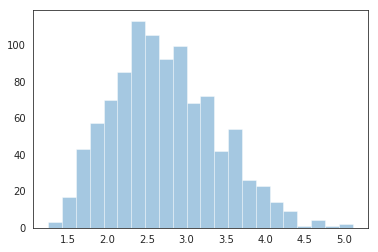

In [11]:
# sampling distribution
_ = sns.distplot(sample_means, kde=False)

### Central Limit Theorem

If all samples are randomly drawn from the same sample population:

For reasonably large samples (usually $n \ge 30$), the distribution of sample mean $\bar{x}$ has is normal regardless of the distribution of $X$.

The sampling distribution of $\bar{x}$ becomes approximately normal as the the sample size $n$ gets large.

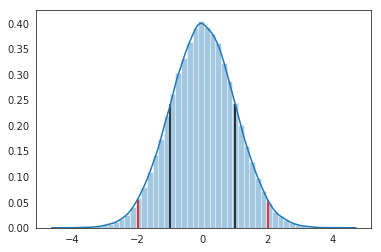

In [12]:
x = np.random.normal(0,1,size=100000)
_ = sns.distplot(x)
_ = plt.vlines([-1,1],0,sp.stats.norm.pdf(1), colors='k')
_ = plt.vlines([-2,2],0,sp.stats.norm.pdf(2), colors='r')

<img src="http://www.statisticshowto.com/wp-content/uploads/2013/09/standard-normal-distribution.jpg">

## Confidence Intervals

### Typically we have one sample, resulting in one sample statistic

In [13]:
n = len(trip_distance)
n 

1000

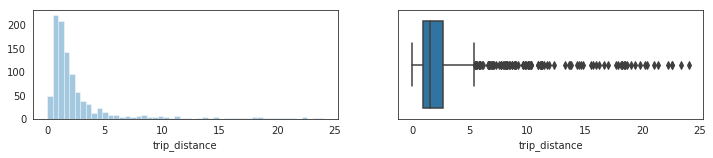

In [51]:
fig,ax = plt.subplots(1,2,figsize=(12,2))
_ = sns.distplot(trip_distance, kde=False, ax=ax[0])
_ = sns.boxplot(trip_distance, ax=ax[1])

In [52]:
x_bar = trip_distance.mean()
x_bar

2.74546

### How variable is that value? What other values might it take?

 - find a range of values that give some notion of the variablity of the statistic
 - confidence interval

### To generate Confidence Intervals

 #### Bootstrap Confidence Interval: sampling **with** replacement  
 
 1. draw a random sample of size *n* from the data
 2. record the sample statistic from this random sample
 3. repeat 1 and 2 many times
 4. for an $x\%$ conf. int., trim off $\frac{1}{2}(1-\frac{x}{100})$ of the data from both ends
 6. those trim points are the endpoints of the the $x\%$ bootstrap confidence interval

In [15]:
def generate_bootstrap(X, size=None):
    # get the length of the data
    len_X = len(X)
    
    # default size of bootstrap is len(X)
    if not size:
        size = len_X

    # resample from X size times
    sample = []
    for i in range(size):
        idx = np.random.randint(len_X)
        sample.append(X[idx])
        
    return sample

In [16]:
# 1. draw a random sample of size *n* from the data
# 2. record the sample statistic from this random sample
# 3. repeat 1 and 2 many times
num_iterations = 500

bootstrap_means = []
for i in range(num_iterations):
    bootstrap = generate_bootstrap(trip_distance.values)
    bootstrap_means.append(np.mean(bootstrap))
    
bootstrap_means = np.array(bootstrap_means)

In [17]:
# 4. for an 95% conf. int., trim off .5*(1-(.95/100)) of the data from both ends
bootstrap_means.sort()

# (.05 / 2) * len(bootstrap_means)
trim = ((1-.95) / 2) * num_iterations

# find the closest integer
trim = int(np.round(trim))
trim

13

In [18]:
# 5. those trim points are the endpoints of the the  x%x%  bootstrap confidence interval
ci = bootstrap_means[[trim,-trim]]
ci

array([2.54455, 2.97011])

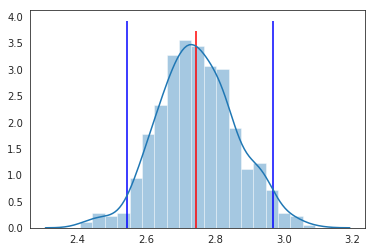

In [19]:
ax = sns.distplot(bootstrap_means)
_ = plt.vlines(trip_distance.mean(), *ax.get_ylim(), color='r')
_ = plt.vlines(ci, *ax.get_ylim(), color='b')

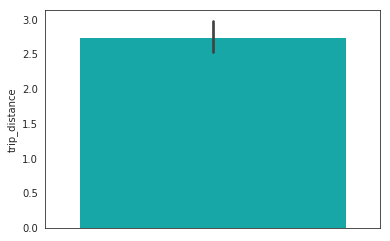

In [20]:
_ = sns.barplot(trip_distance,
                estimator=np.mean,
                ci=95,
                n_boot=100,
                orient='v',
                color='c'
               )

### Meaning of confidence intervals

Tells us something about the *variablity* of this statistic.  

Tells us how confident we should be that our parameter lies in the interval.

It does *not* tell us "the probability the true parameter value lies within that interval".


> If confidence intervals are constructed using a given confidence level from an infinite number of independent sample statistics, the proportion of those intervals that contain the true value of the parameter will be equal to the confidence level.

In [21]:
# or, using a formula
import scipy.stats as st

st.t.interval(0.95,                   # alpha
              len(trip_distance)-1, # shape parameter
              loc=np.mean(trip_distance),
              scale = st.sem(trip_distance))

(2.519168789731736, 2.971751210268264)

## A/B Tests

Do one of two treatments produce superior results?

- testing two prices to determine which generates more profit

- testing two web headlines to determine which produces more clicks

- testing two advertisements to determine which produces more conversions

### Test Statistics / Metrics

- difference in means
- difference in counts

## Hypothesis Testing

#### Null Hypothesis: $H_0$

#### Alternative Hypothesis: $H_1$


given data x: reject or accept the null hypothesis

<pre>
             H_0 true     | H_1 true
            ------------------------------
Accept H_0 | Correct      | Type II error |
            ------------------------------
Reject H_0 | Type I error | Correct       |
            ------------------------------
</pre>

- $p\left(\text{reject } H_0 \mid H_0 \text{ true}\right)$ = significance of test
- $p\left(\text{reject } H_0 \mid H_1 \text{ true}\right)$ = power of test

### Example: Which page leads to more sales?

**Proxy Variables**: a stand in for the true value of interest

Example: what if sales are large but infrequent

Proxy: Assume 'time on internal page' is correlated with sales

In [22]:
session_times = pd.read_csv('../data/web_page_data.csv')
session_times['Time'] = session_times['Time']*100
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


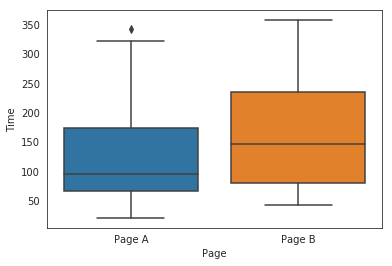

In [23]:
_ = sns.boxplot(x='Page',y='Time',data=session_times)

In [24]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()

In [25]:
observed_metric = mean_b-mean_a
print('{:0.2f}'.format(observed_metric))

35.67


## Is this significant?

> Is this a surprising result given $H_0$?

## Permutation Tests

1. combine groups together
1. permute observations
1. generate new samples (same sizes as originals)
1. calculate metric
1. repeat many times
1. see where our original observation falls

In [26]:
# 0. get group sizes
n_a = sum(session_times.Page == 'Page A')
n_b = sum(session_times.Page == 'Page B')

In [27]:
# 1. combine groups together
samples = session_times.Time

In [28]:
# 2. permute observations
permuted = np.random.permutation(session_times.Time)

In [29]:
# 3. calculate metric
rand_mean_a = permuted[:n_a].mean()
rand_mean_b = permuted[n_a:].mean()
rand_mean_diff = (rand_mean_b - rand_mean_a)
print('{:.2f}'.format(rand_mean_diff))

65.04


In [30]:
# 4. repeat many times
rand_mean_diffs = []
for i in range(10000):
    permuted = np.random.permutation(session_times.Time)
    rand_mean_a = permuted[:n_a].mean()
    rand_mean_b = permuted[n_a:].mean()
    rand_mean_diffs.append(rand_mean_b - rand_mean_a)

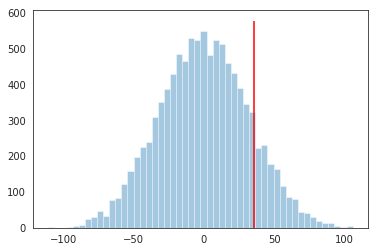

In [31]:
# 5. see where our original observation falls
ax = sns.distplot(rand_mean_diffs, norm_hist=False, kde=False)
_ = plt.vlines(observed_metric, *ax.get_ylim(), color='r')

## Normalization: z-score

1. shift mean to 0
2. standard deviation of 1

$\Large z = \frac{x - \bar{x}}{s}$

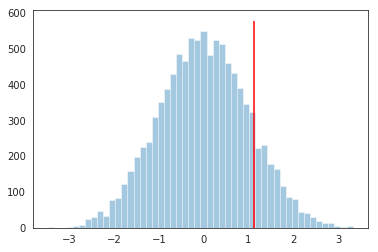

In [34]:
# 5. see where our original observation falls (normalized)
rand_zscores = (rand_mean_diffs - np.mean(rand_mean_diffs)) / np.std(rand_mean_diffs)

ax = sns.distplot(rand_zscores, norm_hist=False, kde=False)
_ = plt.vlines((observed_metric - np.mean(rand_mean_diffs)) / np.std(rand_mean_diffs), *ax.get_ylim(), color='r')

## Why permutation tests?

 - data can be numeric or binary
 - sample sizes can be different
 - assumptions about normally distributed data are not needed

## How sure are we? p-values

> The probability of finding the observed, or more extreme, results when the null hypothesis ($H_0$) is true.

- does mean : $p\left(\text{data} \mid H_0 \text{ is true}\right)$

- does NOT mean : $p\left(H_0 \text{ is not true} \mid \text{data}\right)$

### Our question about signicance becomes:

> "How often did we see a value more extreme than our observed metric?"

In [48]:
# one-tailed

# find means greater than our observed_metric
gt = np.array(rand_mean_diffs) >= observed_metric

# how many are greater?
num_gt = sum(gt)

# proportion of num_gt
p = num_gt / len(rand_mean_diffs)

print(p)

0.1311


In [49]:
# in one line
sum(np.array(rand_mean_diffs) >= observed_metric)/ len(rand_mean_diffs)

0.1311

### One-tailed vs Two-tailed

- Do we have no initial preference for either? Two-tailed

- Does our question imply a direction? One-tailed

In [36]:
# one-tailed
sum(np.array(rand_mean_diffs) >= observed_metric)/ len(rand_mean_diffs)

0.1311

In [37]:
# two-tailed
left_tail  = sum(np.array(rand_mean_diffs) <= -observed_metric)

right_tail = sum(np.array(rand_mean_diffs) >= observed_metric)

(left_tail + right_tail)/ len(rand_mean_diffs)

0.2677

### Another Example: Which price leads to higher conversion?

In [38]:
df = pd.DataFrame({'Price A':[200,23539],'Price B':[182,22406]}, index=['Conversion','No Conversion'])
df

,Price A,Price B
Conversion,200,182
No Conversion,23539,22406


In [39]:
pct_conv = df.loc['Conversion'] / df.sum(axis=0) * 100
pct_conv

Price A    0.842495
Price B    0.805738
dtype: float64

### What's the metric of interest?

In [40]:
diff_pct_conv = pct_conv['Price A'] - pct_conv['Price B']
print('{:.4f}'.format(diff_pct_conv))

0.0368


Reminder:
1. combine groups together
1. permute observations
1. grab two new samples (same sizes as originals)
1. calculate metric
1. repeat many times
1. see where our original observation falls

### What are our samples?

- 1 = Conversion
- 0 = No conversion

### How many samples are there?

In [41]:
n = df.sum().sum()
n

46327

### How do we generate our samples?

In [42]:
n_conversion = df.loc['Conversion'].sum()
n_conversion

382

In [43]:
samples = np.zeros(n)
samples[:n_conversion] = 1

In [44]:
sum(samples) == n_conversion

True

In [45]:
# 0. get group sizes
n_a, n_b = df.sum(axis=0)
n_a, n_b

(23739, 22588)

In [ ]:
n_a + n_b == n

In [ ]:
%%time
rand_conv_diffs = []
for i in range(1000):
    permutation = np.random.permutation(samples)
    rand_conv_a = sum(permutation[:n_a]) / n_a
    rand_conv_b = sum(permutation[n_a:]) / n_b
    rand_conv_diffs.append(100 * (rand_conv_a - rand_conv_b))

In [ ]:
ax = sns.distplot(rand_conv_diffs, norm_hist=False, kde=False)
_ = plt.vlines(diff_pct_conv, *ax.get_ylim(), color='r')

In [ ]:
sum(np.array(rand_conv_diffs) >= diff_pct_conv) / len(rand_conv_diffs)

### Another method: t-test

In [ ]:
# using our session_times example
t = sp.stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time.values,
                       session_times[session_times.Page == 'Page B'].Time.values,
                       equal_var=False)
t.pvalue

In [ ]:
t.pvalue/2

In [ ]:
from statsmodels.stats.weightstats import ttest_ind

In [ ]:
ttest_ind(session_times[session_times.Page == 'Page A'].Time.values,
                       session_times[session_times.Page == 'Page B'].Time.values,
                       usevar='unequal',
                       alternative='smaller')
# t stat, p value, df

In [ ]:
# using our conversion rate example?
group_A = np.zeros(n_a)
group_A[:df.loc['Conversion','Price A']] = 1

group_B = np.zeros(n_b)
group_B[:df.loc['Conversion','Price B']] = 1

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(df.loc['Conversion'],[n_a,n_b],
                  value=0, # value of H_0
                  alternative='larger'
                 )
# z stat, p value

## How many observations do we need?

**effect size**: Min size of effect you want to detect (think "%10 increase in clicks")

**power**: Probability of detecting given effect size with given sample size, $p(\text{reject } H_0 \mid H_1 \text{ true})$

**alpha**: significance level at which to reject the null, $p(\text{reject }H_0 \mid H_0 \text{ true})$

**number of observations**: usually what we're insterested in finding

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
# choose one to set as None
tt_ind_solve_power(effect_size=.05, # difference between means divided by std deviation
                   nobs1=None, 
                   alpha=.05,       # incorrect rejection of a true alternative
                   power=.95,       # 1 - incorrect acceptance of a false null
                   ratio=1          # n_a : n_b
                  )

In [ ]:
# choose one to set as None
tt_ind_solve_power(effect_size=.5, # difference between means divided by std deviation
                   nobs1=None, 
                   alpha=.05,       # incorrect rejection of a true alternative
                   power=.9,        # 1 - incorrect acceptance of a false null
                   ratio=1          # n_a : n_b
                  )

## Issues with multiple testing

- for instance, what if there are more than 2 groups?

- ANOVA

- Multi-Armed Bandit

### $\epsilon$-Greedy MAB

- choose a small $\epsilon$

1. generate random number between 0 and 1
1. if $\lt \epsilon$, roll a die to choose arm
1. if $\ge \epsilon$, choose best arm

### Example

In [ ]:
# have two ads, each of which leads to some unknown response rate
ad_A = sp.stats.bernoulli(p=np.random.rand())
ad_B = sp.stats.bernoulli(p=np.random.rand())

# epsilon probability
e = 0.20

In [ ]:
# round 1, choose A
pulls_A = [ad_A.rvs()]
pulls_A

In [ ]:
# round 2, choose B
pulls_B = [ad_B.rvs()]
pulls_B

In [ ]:
# round 3, 
#    with probability e, randomly choose
#    else choose best

def mab(ad_A,ad_B,pulls_A,pulls_B,e):
    random_choice = np.random.rand() < e

    if random_choice:
        if np.random.rand() < 0.5:
            pulls_A.append(ad_A.rvs())
            choice = 'A'
        else:
            pulls_B.append(ad_B.rvs())
            choice = 'B'
    else:
        resp_A = sum(pulls_A) / len(pulls_A)
        resp_B = sum(pulls_B) / len(pulls_B)
    
        if resp_A > resp_B:
            pulls_A.append(ad_A.rvs())
            choice = 'A'
        else:
            pulls_B.append(ad_B.rvs())
            choice = 'B'
            
    return pulls_A, pulls_B, random_choice, choice

pulls_A, pulls_B, random_choice, choice = mab(ad_A,ad_B,pulls_A,pulls_B,e)
        
print(random_choice,choice,pulls_A, pulls_B)

In [ ]:
for i in range(10):
    pulls_A, pulls_B, random_choice, choice = mab(ad_A,ad_B,pulls_A,pulls_B,e)
    print(random_choice,choice,pulls_A, pulls_B)

In [ ]:
# did we pick the best one?
ad_A.pmf(1), ad_B.pmf(1)

### Issue: exploration vs exploitation

#### Variations

- "Thompson's sampling": uses Baysian approach

- UCB1: maximize expected reward (for arm $j$: $\bar{x}_j + \sqrt{2\log t / n_j}$)